In [1]:
import pandas as pd

import glob

path='c:\\Users\dougw\Desktop\Analise-Polybench\Logs Idle de Energia'

files = [f for f in glob.glob(path + "**/*.txt", recursive=True)]

for f in files:
    print(f)

c:\Users\dougw\Desktop\Analise-Polybench\Logs Idle de Energia\2DCONV_H_A15_HF_1000000_IF_1000000_MF_600000_dev_0_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs Idle de Energia\2DCONV_H_A15_HF_1000000_IF_1000000_MF_600000_dev_1_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs Idle de Energia\2DCONV_H_A15_HF_1000000_IF_1400000_MF_600000_dev_0_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs Idle de Energia\2DCONV_H_A15_HF_1000000_IF_1400000_MF_600000_dev_1_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs Idle de Energia\2DCONV_H_A15_HF_1000000_IF_400000_MF_600000_dev_0_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs Idle de Energia\2DCONV_H_A15_HF_1000000_IF_400000_MF_600000_dev_1_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs Idle de Energia\2DCONV_H_A15_HF_1400000_IF_1000000_MF_600000_dev_0_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs Idle de Energia\2DCONV_H_A15_HF_1400000_IF_1000000_MF

In [2]:
def group_results(file,name):
    df_temp = pd.DataFrame()
    dict_temp = {}    

    for line in file:
        if 'make' in line:
            continue
        else:
            if ":" in line:
                #print(line.split(':')[1].replace('s',''))
                key, value = line.split(':')[0], float(line.split(':')[1].replace('s',''))
                dict_temp[key] =  float(value)
                #print(key,':',value)
            else: 
                if 'm' in line:
                    key = line.split('\t')[0]
                    mi = int(line.split('\t')[1].split('m')[0])
                    se = float(line.split('\t')[1].split('m')[1].replace('s',''))
                    value = mi*60 + se
                    dict_temp[key] =  float(value)
                    #print(key,':',value)
                    if "sys" in line:
                        df_temp = df_temp.append(dict_temp, ignore_index=True)
                        dict_temp = dict.fromkeys(dict_temp, 0)

    df_temp = df_temp.mean().to_dict()
    
    app = name.split('\\')[-1].split('_')[0]
    Host = name.split('_')[2]
    Host_freq = int(name.split('_')[4])
    idle1_freq = int(name.split('_')[6])
    if Host == 'A15':
        idle1_dev = 'A7'
    
    if Host == 'A7':
        idle1_dev = 'A15'
    
    if(int(name.split('_')[10]) == 0):
        dev = 'GPU'
        dev_freq = 600000000.0
        idle1_dev = name.split('_')[2]
        idle1_freq = int(name.split('_')[4])
        if idle1_dev == 'A15':
            idle2_dev = 'A7'
    
        if idle1_dev == 'A7':
            idle2_dev = 'A15'
    
        idle2_freq = int(name.split('_')[6])
    else:
        dev = Host
        dev_freq = Host_freq
        idle2_dev = 'GPU'
        idle2_freq = 600000000.0
        
    df_temp['App'] = app
    df_temp['Host'] = Host
    #df_temp['Host_freq'] = Host_freq
    df_temp['Freq'] = dev_freq
    df_temp['Dev'] = str(dev)
    df_temp['Idle1'] = idle1_dev
    df_temp['Idle1_Freq'] = idle1_freq
    df_temp['Idle2'] = idle2_dev
    df_temp['Idle2_Freq'] = idle2_freq
    
    return df_temp

In [3]:
df = pd.DataFrame()

for path in files:
    log_data=open(path,'r')
    temp_dict = group_results(log_data, path)
    df = df.append(temp_dict, ignore_index=True)
    col = df['Idle2_Freq']
    df.drop(labels=['Idle2_Freq'], axis=1,inplace = True)
    df.insert(0, 'Idle2_Freq', col)
    col = df['Idle2']
    df.drop(labels=['Idle2'], axis=1,inplace = True)
    df.insert(0, 'Idle2', col)
    col = df['Idle1_Freq']
    df.drop(labels=['Idle1_Freq'], axis=1,inplace = True)
    df.insert(0, 'Idle1_Freq', col)
    col = df['Idle1']
    df.drop(labels=['Idle1'], axis=1,inplace = True)
    df.insert(0, 'Idle1', col)
    col = df['Freq']
    df.drop(labels=['Freq'], axis=1,inplace = True)
    df.insert(0, 'Freq', col)
    col = df['Dev']
    df.drop(labels=['Dev'], axis=1,inplace = True)
    df.insert(0, 'Dev', col)
    col = df['Host']
    df.drop(labels=['Host'], axis=1,inplace = True)
    df.insert(0, 'Host', col)
    col = df['App']
    df.drop(labels=['App'], axis=1,inplace = True)
    df.insert(0, 'App', col)


In [4]:
df['Config'] = df['Dev']+':'+df['Freq'].astype(str) + '|' + df['Idle1']+':'+df['Idle1_Freq'].astype(str) +'|'+ df['Idle2'] +':'+ df['Idle2_Freq'].astype(str)

In [5]:
to_remove = ['App','Host','Dev','Freq','Idle1','Idle1_Freq','Idle2','Idle2_Freq','real','sys','user']
df['Total_Acumulada'] = df.loc[:,~df.columns.isin(to_remove)].sum(axis=1)

df['EDP'] = df['Total_Acumulada']*df['real']
df['A15_Power'] = df['A15_Acumulada']/df['real']
df['A7_Power'] = df['A7_Acumulada']/df['real']
df['MEM_Power'] = df['MEM_Acumulada']/df['real']
df['GPU_Power'] = df['GPU_Acumulada']/df['real']
df

App Host  Dev         Freq Idle1  Idle1_Freq Idle2   Idle2_Freq  \
0    2DCONV  A15  GPU  600000000.0   A15   1000000.0    A7    1000000.0   
1    2DCONV  A15  A15    1000000.0    A7   1000000.0   GPU  600000000.0   
2    2DCONV  A15  GPU  600000000.0   A15   1000000.0    A7    1400000.0   
3    2DCONV  A15  A15    1000000.0    A7   1400000.0   GPU  600000000.0   
4    2DCONV  A15  GPU  600000000.0   A15   1000000.0    A7     400000.0   
..      ...  ...  ...          ...   ...         ...   ...          ...   
667    SYRK   A7   A7     400000.0   A15   1400000.0   GPU  600000000.0   
668    SYRK   A7  GPU  600000000.0    A7    400000.0   A15    2000000.0   
669    SYRK   A7   A7     400000.0   A15   2000000.0   GPU  600000000.0   
670    SYRK   A7  GPU  600000000.0    A7    400000.0   A15     400000.0   
671    SYRK   A7   A7     400000.0   A15    400000.0   GPU  600000000.0   

     A15_Acumulada  A7_Acumulada  ...     real     sys     user  \
0         3.359609      0.393837  ...   6.0376  1.1083   4.7077   
1         4.311673      0.423279  ...   6.1519  1.0010   5.7060   
2         3.257579      0.727040  ...   6.0206  1.0839   4.7250   
3         4.421417      0.821155  ...   6.1184  0.9802   5.7242   
4         3.651329      0.156945  ...   6.1716  1.1871   4.7486   
..             ...           ...  ...      ...     ...      ...   
667      10.645015      1.482102  ...  15.7225  0.4164  52.9663   
668       6.918172      0.171078  ...   4.9743  0.3851   0.5308   
669      24.178340      1.496779  ...  15.7179  0.3968  53.0196   
670       1.222401      0.164158  ...   5.0289  0.4589   0.5664   
671       3.722714      1.484596  ...  16.1309  0.4644  54.1741   

                                         Config  Total_Acumulada         EDP  \
0    GPU:600000000.0|A15:1000000.0|A7:1000000.0         4.710669   28.441137   
1    A15:1000000.0|A7:1000000.0|GPU:600000000.0         5.800258   35.682610   
2    GPU:600000000.0|A15:1000000.0|A7:1400000.0         4.917054   29.603614   
3    A15:1000000.0|A7:1400000.0|GPU:600000000.0         6.301024   38.552188   
4     GPU:600000000.0|A15:1000000.0|A7:400000.0         4.965702   30.646328   
..                                          ...              ...         ...   
667   A7:400000.0|A15:1400000.0|GPU:600000000.0        14.740987  231.765170   
668   GPU:600000000.0|A7:400000.0|A15:2000000.0        14.619838   72.723461   
669   A7:400000.0|A15:2000000.0|GPU:600000000.0        28.282861  444.547184   
670    GPU:600000000.0|A7:400000.0|A15:400000.0         8.745998   43.982749   
671    A7:400000.0|A15:400000.0|GPU:600000000.0         7.861527  126.813499   

     A15_Power  A7_Power  MEM_Power  GPU_Power  
0     0.556448  0.065231   0.090088   0.068456  
1     0.700869  0.068805   0.107371   0.065796  
2     0.541072  0.120759   0.085595   0.069279  
3     0.722643  0.134211   0.106824   0.066171  
4     0.591634  0.025430   0.098565   0.088976  
..         ...       ...        ...        ...  
667   0.677056  0.094266   0.107216   0.059034  
668   1.390783  0.034392   0.334042   1.179857  
669   1.538268  0.095228   0.105880   0.060029  
670   0.243075  0.032643   0.320083   1.143346  
671   0.230782  0.092034   0.103663   0.060880  

[672 rows x 22 columns]

In [14]:
apps = list(set(df['App']))
df_config_plot = pd.DataFrame()

for app in apps:
    df_edp = df[df['App'] == app]
    df_edp = df_edp.sort_values('EDP')
    df_edp = df_edp.reset_index()
    
    to_add = []
    for i in range(10):
        to_add.append(df_edp.iloc[i])
        
    df_config_plot = df_config_plot.append(to_add, ignore_index=True)
    df_config_plot = df_config_plot.drop(columns=['index'])


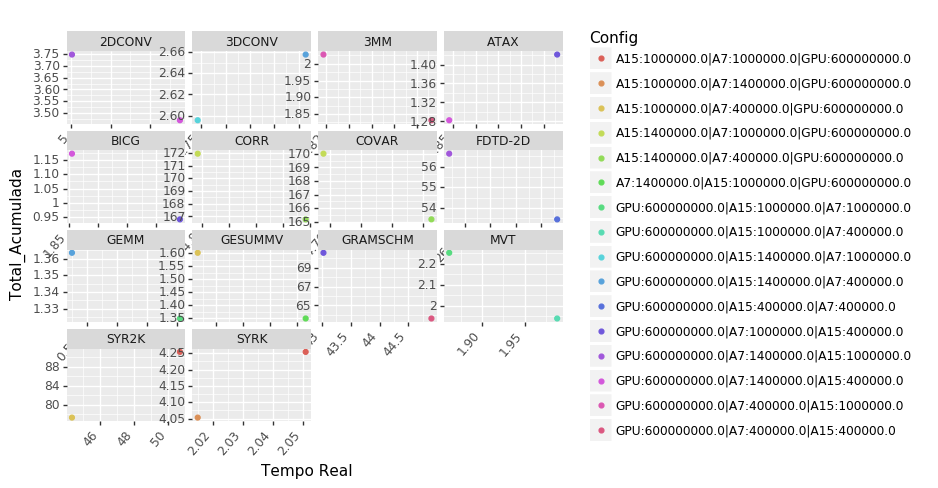

<ggplot: (137235821888)>

In [13]:
from plotnine import *
#for app in apps:
(ggplot(df_config_plot, aes(x='real', y='Total_Acumulada',color = 'Config')) +\
     geom_point() +\
     facet_wrap(["App"], scales = "free") +\
     labs(x = "Tempo Real") +\
     theme(axis_text_x = element_text(angle=50, hjust=1))
)